In [117]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import pandas as pd

In [120]:
get_ipython().run_line_magic('matplotlib', 'inline')

### Plot Setting

In [122]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### Read Dataset

In [124]:
#Dataset Path
path = 'database/'
window_size = 160
maximum_counting = 10000

X = list() #data
y = list() #labels

In [126]:
# Read Filenames
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)


#### Arrhythmia Annotation
 - N = Normal beat
 - L = Left bundle branch block beat
 - R = Right bundle branch block beat
 - e = Atrial escape beat
 - j = Nodal (junctional) escape beat
 - A = Atrial premature beat
 - a = Aberrated atrial premature beat
 - J = Nodal (junctional) premature beat
 - S = Supraventricular premature or ectopic beat (atrial or nodal)
 - V = Premature ventricular contraction
 - E = Ventricular escape beat
 - F = Fusion of ventricular and normal beat
 - / = Paced beat
 - f = Fusion of paced and normal beat
 
#### The Number of Each Arrhythmia Type
 - N = 10001
 - L = 8075
 - R = 7259
 - e = 16
 - j = 229
 - A = 2546
 - a = 150
 - J = 83
 - S = 2
 - V = 7130
 - E = 106
 - F = 803
 - / = 7028
 - f = 982

In [128]:
classes = ['N','L','R','A','V','/']
n_classes = len(classes)
count_classes = [0] * n_classes

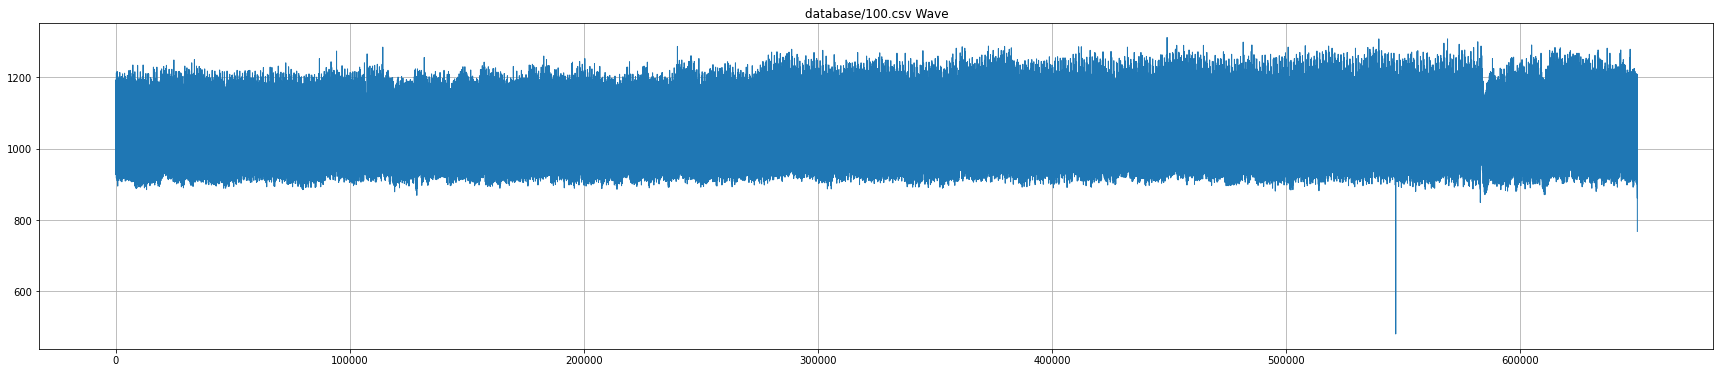

In [130]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 0:
        # Plot each patient's signal
        plt.title(records[0] + " Wave")
        plt.plot(signals)
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size+1:pos+window_size]
                        X.append(beat)
                        y.append(arrhythmia_index)

In [132]:
np.shape(X) 

(55074, 319)

In [134]:
np.shape(y)

(55074,)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [138]:
scaler1 = StandardScaler()
scaler1.fit(X)
feature_scaled = scaler1.transform(X)

In [140]:
model_pca = PCA(n_components = 6)
model_pca.fit(feature_scaled)
feature_scaled_pca = model_pca.transform(feature_scaled)
print("Shape of the scaled and PCA'ed Features: ", np.shape(feature_scaled_pca))


Shape of the scaled and PCA'ed Features:  (55074, 6)


In [142]:
feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))

print("Variance Ratio of the 6 Principal Components Analysis: ", feat_var_rat)


Variance Ratio of the 6 Principal Components Analysis:  [0.61732629 0.14787079 0.12016465 0.04368477 0.03955211 0.03140139]


In [144]:
X_train, X_test, y_train, y_test = train_test_split(feature_scaled_pca, y, test_size=0.33)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))


X_train :  36899
X_test  :  18175
y_train :  Counter({0: 6766, 5: 6740, 4: 6686, 1: 6639, 2: 6614, 3: 3454})
y_test  :  Counter({2: 3382, 1: 3357, 4: 3314, 5: 3253, 0: 3231, 3: 1638})


In [146]:
from sklearn.svm import SVC 
C_value = 4
gamma_value = 'auto'
use_probability = False
multi_mode = 'ovo'

svm_model = SVC(C=C_value, kernel='rbf', degree=3, gamma=gamma_value,  
                    coef0=0.0, shrinking=True, probability=use_probability, tol=0.001, 
                    cache_size=200, verbose=False, 
                    max_iter=-1, decision_function_shape=multi_mode, random_state=None)
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test) 
  
# model accuracy for X_test   
accuracy_2 = svm_model.score(X_test, y_test) 
  
# creating a confusion matrix 
cm_2 = confusion_matrix(y_test, svm_predictions)



Test Accuracy: 95.174691%

Normalized confusion matrix


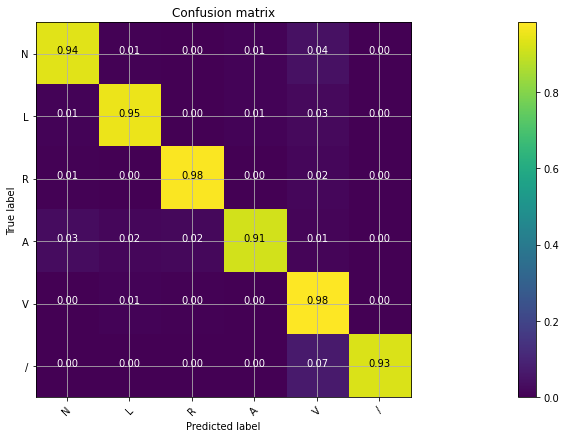

In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print("\nTest Accuracy: {0:f}%\n".format(accuracy_2*100))
plot_confusion_matrix(cm_2, classes, normalize=True)



In [152]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)
predictions_knn = knn.predict(X_test) 
accuracy_knn = knn.score(X_test, y_test) 
cm_knn = confusion_matrix(y_test, predictions_knn)


Test Accuracy: 96.775791%

Normalized confusion matrix


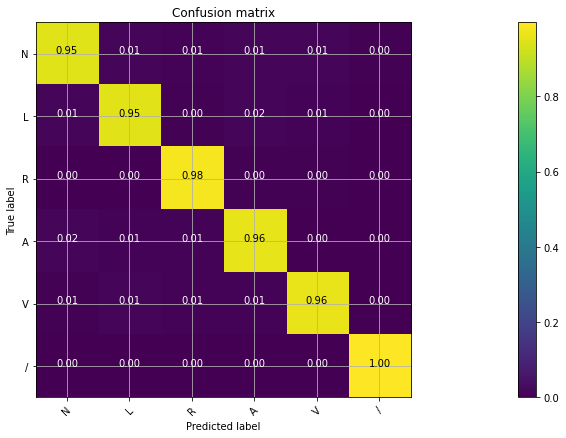

In [153]:
print("\nTest Accuracy: {0:f}%\n".format(accuracy_knn*100))
plot_confusion_matrix(cm_knn, classes, normalize=True)

In [155]:
from sklearn.ensemble import RandomForestClassifier
rtree = RandomForestClassifier()
rtree.fit(X_train,y_train)
predictions_rtree = rtree.predict(X_test)
accuracy_rtree = rtree.score(X_test, y_test) 
cm_rtree = confusion_matrix(y_test, predictions_rtree)



Test Accuracy: 97.089409%

Normalized confusion matrix


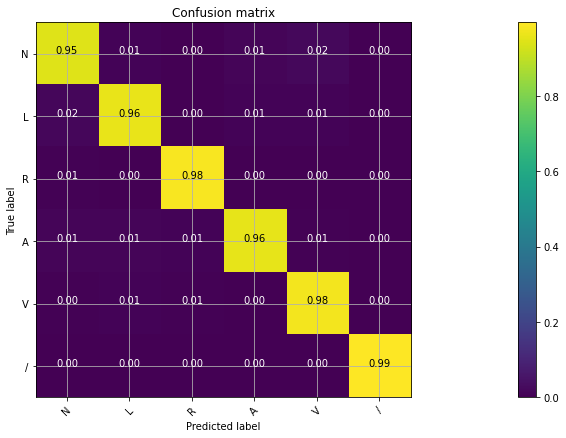

In [156]:
print("\nTest Accuracy: {0:f}%\n".format(accuracy_rtree*100))
plot_confusion_matrix(cm_rtree, classes, normalize=True)